## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [74]:
#+==============================================================
#
# Start here. 
#
#===============================================================
import os
import numpy as np
import cv2
import glob
import matplotlib; matplotlib.use('Qt4Agg')
from matplotlib import pyplot as plt
%matplotlib qt



import pickle
import matplotlib.image as mpimg


In [75]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)

objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

In [107]:
# Step through the list and search for chessboard corners
img_store = []

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)
        img_store.append(img)
#cv2.destroyAllWindows()

# now plot all the images 


In [108]:
#==========================================================
#
# Camera calibration and
#
# from class material with edits
#
#==========================================================

# calibrate
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

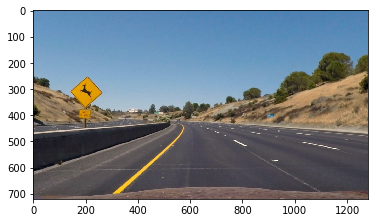

In [109]:
#==========================================================
#
# Undistort Image
#
# from class material with edits
#
#==========================================================

#img = cv2.imread('test_image2.png')

%matplotlib inline

# grab an example 
image = plt.imread('../test_images/test2.jpg')

#image = 
def undistort(image):
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    return undistorted

undistorted = undistort(image)
plt.imshow(undistorted)

In [110]:
#==========================================================
#
# Color space and sobel operator for comvined threshold 
#
# from class material with edits
#
#==========================================================


#import numpy as np
##import cv2
#import matplotlib.pyplot as plt
#import matplotlib.image as mpimg

img = undistorted

# reads in undistorted image and outputs binary image as a combo of different thresholded images
def apply_thresholds(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))*255
    
    # from the class notes
    combined_binary = np.zeros_like(sxbinary)
    
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    # make the picture color binary rather than all one channel for each threshold
    #color_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    #combined_binary = cv2.cvtColor(combined_binary, cv2.COLOR_RGB2BGR).astype(np.float)
    
    return combined_binary

# test.    
result = apply_thresholds(img)


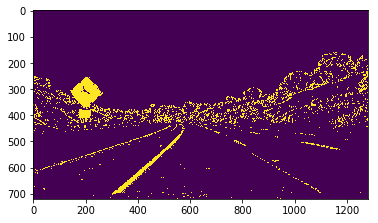

In [111]:
plt.imshow(result)
#np.unique(s_binary)

In [112]:
result.shape

(720, 1280)

In [113]:
#==========================================================
#
# Make a warped version of the binary image  
#
# from class material with edits
#
# Should output a 'birds-eye-view' of the road
#
#==========================================================
def warp(img, mtx, dist):
    
    img_size = (img.shape[1], img.shape[0])
    
    # !!! Source points!! hand picked, trail and error and looking at x y values in gimp
    # 580 WAS 600
    offset = 150
    src = np.float32([[600, 450], [780, 450], [1150, 670], [250, 670]])
    dst = np.float32([[offset, 0], [img_size[0] - offset, 0], [img_size[0] - offset, img_size[1]], [offset, img_size[1]]])
    # Given src and dst points, cculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # get the inverse
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix (for unwarp)
    return warped, M, Minv

#===============================================================================
# test run
img = result
test, M, Minv = warp(img, mtx, dist)

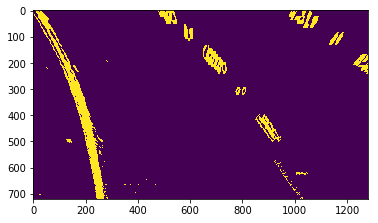

In [114]:
plt.imshow(test)
#plt.imsave('test.png', test)

#Plot the result

#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()

#ax1.imshow(image)
#ax1.set_title('Original Image', fontsize=40)

#ax2.imshow(result)
#ax2.set_title('Pipeline Result', fontsize=40)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [115]:
#==========================================================
#
# Make a warped version of the binary image  
#
# from class material with edits
#
# Should output a 'birds-eye-view' of the road
#
#==========================================================
# pre function test: 
binary_warped = test


# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))#*255
#out_img = binary_warped

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 20
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

#==================================================
# These are saved and put into the final pipe line function
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

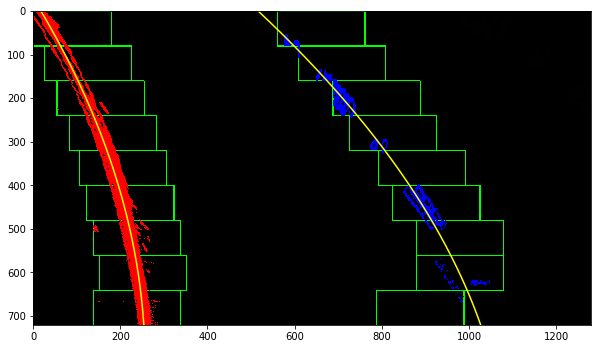

In [116]:
# set plot size 
matplotlib.rcParams['figure.figsize'] = (10,10)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [117]:
#==========================================================
#
# from the class notes 
#
# with edits 
# 
# This is for fitting after the first image
#===========================================================

# This function will be looped in the pipeline, accepting the 
#   new warped image and the origian right_fit and left_fit 
def ploy_fit(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, lefty, righty, leftx, rightx, left_fit, right_fit

left_fitx, right_fitx, lefty, righty, leftx, rightx, left_fit, right_fit = ploy_fit(binary_warped, left_fit, right_fit)

(720, 0)

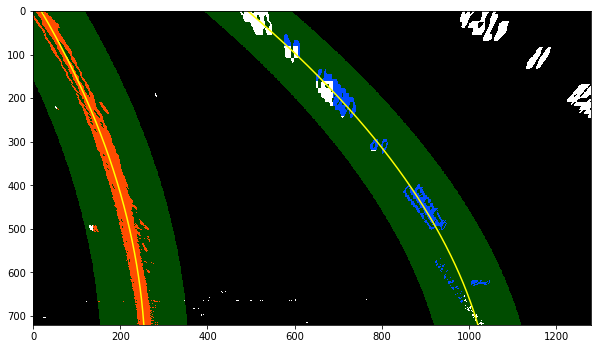

In [118]:
#==========================================================
#
# from the class notes 
#
# with edits 
# 
# This final visualization for the warped lane lines 
#===========================================================

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [119]:

len(leftx)*0.25

len(leftx) - len(leftx)*0.25

v = leftx[int(len(leftx) - len(leftx)*0.25) : len(leftx)]

np.mean(leftx)

np.mean(v)

243.67259330450105

In [120]:
#===================================================
#
#
# from class material and inspired by: 
# [https://github.com/sumitbinnani/CarND-Advanced-Lane-Lines/blob/master/Pipeline%20for%20Advance%20Lane%20Detection.ipynb]
#===================================================

##ym_per_pix = 3/72.0 # meters per pixel in y dimension
#xm_per_pix = 3.7/660.0 # meters per pixel in x dimension
#y_eval = 700
#midx = 650
def calc_radius(left_fit, right_fit, lefty, righty, leftx, rightx):
    # from class notes, replace ploty with fity
    y_eval = 720
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension


    # Fit new polynomials to x,y in world space
    # !! replace ploty with lefty and righty
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Now our radius of curvature is in meters and I' going to take the minimum
    
    #curvature =(left_curverad, 'm', right_curverad, 'm')
    curvature_text = np.round(np.min([left_curverad, right_curverad]), 0)
    
    # now calcuate postition from right and left lane lines
    # but only from the bottom 25% of the fit
    left_ave = np.mean(leftx[int(len(leftx) - len(leftx)*0.25) : len(leftx)])
    right_ave = np.mean(rightx[int(len(rightx) - len(rightx)*0.25) : len(rightx)])
    
    
    m_from_left = np.round((640 - left_ave)*xm_per_pix, 2)
    m_from_right = np.round((right_ave - 640)*xm_per_pix, 2)
    
    center_text = [m_from_left,  m_from_right]
    

    #print("Radius of Curvature: %f" % curvature)
    return curvature_text, center_text

#===========================================================================================
# test 
calc_radius(left_fitx, right_fitx, lefty, righty, leftx, rightx)



(270.0, [2.0899999999999999, 1.53])

In [121]:
#eft_ave = np.mean(leftx)*xm_per_pix
right_ave = (np.mean(rightx) - 640)*(3.7/700)
right_ave


0.45341848909882937

In [122]:
#=======================================================================================
# Define the line class for video processing 
#
#  From class notes, but simplified
#=====================================================================================

# Define a class to receive the characteristics of each line detection
class lane():
    def __init__(self):
        self.last_fits = None


In [123]:
right_fit

array([ -6.09130253e-04,   1.17210578e+00,   4.92244933e+02])

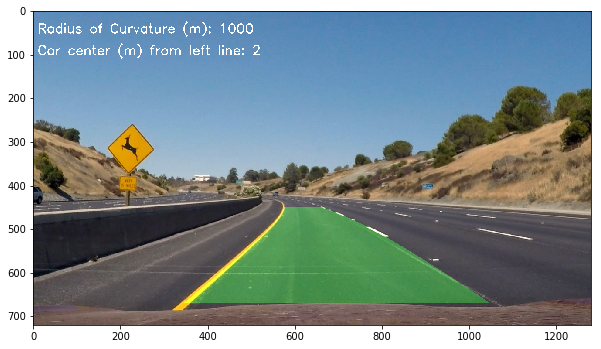

In [124]:
#==========================================================
#
# from the class notes 
#
# with edits 
# 
# plots the lane line back onto the image
#=======================================================

def draw_lane(test, image, left_fitx, right_fitx, curve_text, center_text):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(test).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Get the new poly fits  
    #left_fitx, right_fitx = ploy_fit(binary_warped, left_fit, right_fit)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    #result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        
    font = cv2.FONT_HERSHEY_SIMPLEX
    curve_text = 'Radius of Curvature (m): ' + str(curve_text)
    
    # now lane distance. Add this commented out line to print out dist from right line also
    #+ ' & right line: ' + str(center_text[1])
    center_text = 'Car center (m) from left line: ' + str(center_text[0])
    image_text1 = cv2.putText(result, curve_text, (10,50), font, 1, (255,255,255),2)
    image_text2 = cv2.putText(image_text1, center_text, (10,100), font, 1, (255,255,255),2)
    
    #result = cv2.addWeighted(image_text2, 1, newwarp, 0.3, 0)
    
    return image_text2

# test the draw function
# just to test, put in hard values
result = []
result = draw_lane(test, image, left_fitx, right_fitx, 1000, [2, 1])
plt.imshow(result)

In [125]:
#==========================================================
#
# fCreate functions to save n poly fits and average them to get the next 
#
# effectively, this gives the lane a little bit of "delay" which may make the lane predictions smoother 
#
#=======================================================
# define a function to store and average previous fits in attempt to smooth out the line
def average_fit(prev, n):
    ave_fit = np.zeros([3])
    for i in range(0, 3):
        ave_fit[i] = np.average(prev[0:n, i:i+1].transpose(), axis = 1, weights = np.linspace(.1, n*.1, n, endpoint=False))
    return ave_fit


def lane_step(prev, current, n):
    for i in range(0, n-1):
        prev[i:i+1, :] = prev[i+1:i+2, :]
    prev[n-1:n, :] = current
    return prev

# initilize the test fit object
te = np.zeros([9, 3])
te[0:] = left_fit
te[1:] = right_fit
te[2:] = left_fit
te[3:] = right_fit
te[4:] = left_fit
te[5:] = right_fit
te[6:] = left_fit
te[7:] = right_fit
te[8:] = left_fit

# test 
average_fit(te, 9)

te


#type(te[0:n, i:i+1].transpose())


#type(np.linspace(.1, n*.1, n, endpoint=False))

#average_fit(te, 9)
#i = 1
#shape(te[0:i+1, :] = te[i+1:i+2, :])
#te

#n = 9
#np.linspace(.1, n*.1, n, endpoint=False)

array([[ -3.56294672e-04,   5.83649828e-01,   1.85279578e+01],
       [ -6.09130253e-04,   1.17210578e+00,   4.92244933e+02],
       [ -3.56294672e-04,   5.83649828e-01,   1.85279578e+01],
       [ -6.09130253e-04,   1.17210578e+00,   4.92244933e+02],
       [ -3.56294672e-04,   5.83649828e-01,   1.85279578e+01],
       [ -6.09130253e-04,   1.17210578e+00,   4.92244933e+02],
       [ -3.56294672e-04,   5.83649828e-01,   1.85279578e+01],
       [ -6.09130253e-04,   1.17210578e+00,   4.92244933e+02],
       [ -3.56294672e-04,   5.83649828e-01,   1.85279578e+01]])

In [126]:
lane_step(te, left_fit, 9)

array([[ -6.09130253e-04,   1.17210578e+00,   4.92244933e+02],
       [ -3.56294672e-04,   5.83649828e-01,   1.85279578e+01],
       [ -6.09130253e-04,   1.17210578e+00,   4.92244933e+02],
       [ -3.56294672e-04,   5.83649828e-01,   1.85279578e+01],
       [ -6.09130253e-04,   1.17210578e+00,   4.92244933e+02],
       [ -3.56294672e-04,   5.83649828e-01,   1.85279578e+01],
       [ -6.09130253e-04,   1.17210578e+00,   4.92244933e+02],
       [ -3.56294672e-04,   5.83649828e-01,   1.85279578e+01],
       [ -3.56294672e-04,   5.83649828e-01,   1.85279578e+01]])

In [127]:
#=======================================================================================
#
# build the whole pipeline for processing images with the above code and functions 
#
# 
#=====================================================================================

def image_pipeline(input_image):
    # get teh undistorted warped base image 
    undistorted = undistort(input_image)
    thresholded = apply_thresholds(undistorted, s_thresh=(90, 240), sx_thresh=(60, 160))
    warped, M, Minv = warp(thresholded, mtx, dist)
    
    # calcualte the average fits for the last 4 fits
    ave_right_fit = average_fit(right_lane.last_fits, 200)
    ave_left_fit = average_fit(left_lane.last_fits, 200)
    
    # continue down the pipe from poly fit function
    left_fitx, right_fitx, lefty, righty, leftx, rightx, left_fit, right_fit = ploy_fit(warped, ave_left_fit, ave_right_fit)
    curve_feed, center_feed = calc_radius(left_fitx, right_fitx, lefty, righty, leftx, rightx)
    result = draw_lane(warped, input_image, left_fitx, right_fitx, curve_text = curve_feed, center_text = center_feed)
    
    # keep the fits rolling through the lane classes  
    right_lane.last_fits = lane_step(right_lane.last_fits, right_fit, 200)
    left_lane.last_fits = lane_step(left_lane.last_fits, left_fit, 200)
    
    # get the final image
    return result

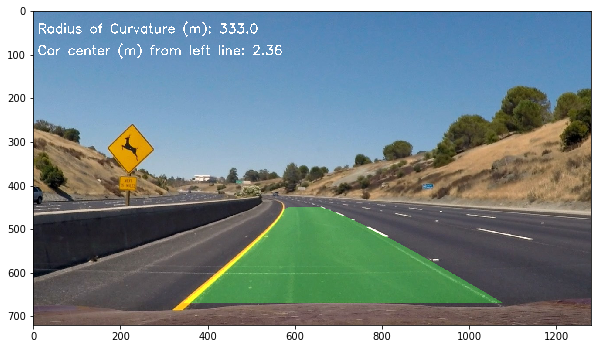

In [103]:
#=======================================================================================
#
# Initilize line classes and test pipeline on test image 
#
# 
#=====================================================================================

# Create the object 
right_lane = lane()
left_lane = lane()

# initilize with test 1

# initilize the fit objects
n = 200
l_start = np.zeros([n, 3])
for i in range(0, n): 
    l_start[i:] = left_fit

r_start = np.zeros([n, 3])
for i in range(0, n): 
    r_start[i:] = right_fit

right_lane.last_fits = r_start
left_lane.last_fits = l_start
    
i_im = plt.imread('../test_images/test2.jpg')
 
ts = image_pipeline(i_im)
plt.imshow(ts)

In [51]:
right_lane.last_fits

array([[ -6.51272939e-04,   1.38999102e+00,   4.04805154e+02],
       [ -6.51272939e-04,   1.38999102e+00,   4.04805154e+02],
       [ -6.51272939e-04,   1.38999102e+00,   4.04805154e+02],
       [ -6.51272939e-04,   1.38999102e+00,   4.04805154e+02],
       [ -6.51272939e-04,   1.38999102e+00,   4.04805154e+02],
       [ -6.51272939e-04,   1.38999102e+00,   4.04805154e+02],
       [ -6.51272939e-04,   1.38999102e+00,   4.04805154e+02],
       [ -6.51272939e-04,   1.38999102e+00,   4.04805154e+02],
       [ -6.51272939e-04,   1.38999102e+00,   4.04805154e+02],
       [ -6.51272939e-04,   1.38999102e+00,   4.04805154e+02],
       [ -6.51272939e-04,   1.38999102e+00,   4.04805154e+02],
       [ -6.51272939e-04,   1.38999102e+00,   4.04805154e+02],
       [ -6.51272939e-04,   1.38999102e+00,   4.04805154e+02],
       [ -6.51272939e-04,   1.38999102e+00,   4.04805154e+02],
       [ -6.51272939e-04,   1.38999102e+00,   4.04805154e+02],
       [ -6.51272939e-04,   1.38999102e+00,   4.0480515

In [44]:
right_fit

array([ -6.51272939e-04,   1.38999102e+00,   4.04805154e+02])

In [104]:
#=======================================================================================
#
#  Processing the videos 
#
# Citations: [https://github.com/mvirgo/Advanced-Lane-Lines/blob/master/full_pipeline.py]
# and [https://pypi.python.org/pypi/moviepy]
# and [https://stackoverflow.com/questions/40965423/how-to-use-fl-image-function-in-moviepy-within-python]
#=====================================================================================

# Import moviepy to stream movie through the pipeline function. 
from moviepy.editor import VideoFileClip

# loop the pipeline function over the video one frame at a time. 
original_video = VideoFileClip("../project_video.mp4")
lane_video = original_video.fl_image(image_pipeline)

# writes out the video to 
lane_video.write_videofile('../test1.mp4', audio=False)

[MoviePy] >>>> Building video ../test1.mp4
[MoviePy] Writing video ../test1.mp4


100%|█████████▉| 1260/1261 [02:13<00:00,  8.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../test1.mp4 



In [ ]:
#========================================================================================
#
#
#
#
#=========================================================================================